## Regression problem with categorical feature

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import Lasso
from sklearn.linear_model    import Ridge

from sklearn.linear_model    import ElasticNet 
from sklearn.model_selection import GridSearchCV

from pathlib import Path
import os

In [2]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


### Load dataset

In [58]:
# import dataset
path_dataset = path_root / 'dataset/gm_2008_region.csv'
data  = pd.read_csv(path_dataset)
data.head(3)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,America


### Create dummy Variables for `Region` feature
Normally dummy variables can be created as follow: `df_augmented = pd.get_dummies(df)`. However, for prediction purposes we can drop one dummy feature to avoid *feature redundancy*

In [61]:
# Create dummy variables and drop the unneeded dummy variable (in this case, 'Region_America')
data_aug = pd.get_dummies(data, drop_first=True)
# Print the new columns of df_region
print(f"# of category within `Region` feature = {len(data['Region'].unique())}")
print(f"# of original df = {data.shape[1]} | # of augmented dataframe = {data_aug.shape[1]}")
data_aug.head(3)   

# of category within `Region` feature = 6
# of original df = 10 | # of augmented dataframe = 14


,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region_East Asia & Pacific,Region_Europe & Central Asia,Region_Middle East & North Africa,Region_South Asia,Region_Sub-Saharan Africa
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,0,0,1,0,0
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,0,0,0,0,1
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,0,0,0,0,0


In [62]:
X    = data_aug.drop(['life'], axis = 1) 
y    = data_aug['life']
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

### Train linear regression model

In [63]:
reg_all = LinearRegression()
# Fit the regressor to the training data
reg_all.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

In [64]:
# Compute and print R^2 and RMSE
print(f"R^2: {round(reg_all.score(X_test, y_test), 2)}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {round(rmse, 2)}")

R^2: 0.82
Root Mean Squared Error: 3.41


### Train linear regression with Cross validation

In [65]:
reg_all = LinearRegression()
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all, X, y, cv = 5)

In [66]:
# Print the 5-fold cross-validation scores
print(cv_scores)
print(f"Average 5-Fold CV Score R^2: {round(np.mean(cv_scores), 2)}")

[0.8196741  0.80301541 0.89758712 0.80425614 0.94015848]
Average 5-Fold CV Score R^2: 0.85


### Linear regression with Ridge regularization
Analysis of optimal regularization term $\alpha$. 

In [67]:
# Setup the array of alphas and lists to store scores
kfold            = 10 
alpha_space      = np.logspace(-4, 0, 50)
ridge_scores     = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize = True)

In [68]:
# Compute scores over range of alphas
for alpha in alpha_space:
    #print(f"alpha = {alpha}")
    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha   
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = kfold)   
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))   
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

In [71]:
def display_plot(cv_scores, cv_scores_std, kfold):
    # get best value
    temp = {'alpha': alpha_space ,'CV_mean': ridge_scores, 'CV_std': ridge_scores_std}
    rigde_results = pd.DataFrame(temp)
    _ = rigde_results.sort_values(by = ['CV_mean', 'CV_std'], axis = 0, ascending = [False, True], inplace = True)
    best_value = rigde_results.iloc[0]
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)
    std_error = cv_scores_std / np.sqrt(kfold)
    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(best_value.CV_mean, linestyle='--', color='r', linewidth = 0.8)
    ax.axvline(best_value.alpha,  linestyle='--', color='r', linewidth = 0.8)
    plt.plot(best_value.alpha, best_value.CV_mean, 'ro')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.title(f'Analysis or alpha for Ridge regression \n Best CV score = {round(best_value.CV_mean, 2)} for alpha = {round(best_value.alpha, 2)}')
    plt.grid()
    plt.show()

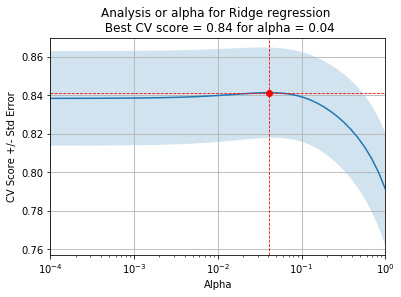

In [72]:
# NB: the optimal alpha is close to 0.1 where the red line touch the max cv_score 
display_plot(ridge_scores, ridge_scores_std, kfold)

### Feature selection via Lasso

In [73]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = 0.1, normalize = True)
# Fit the regressor to the data
lasso.fit(X,y)
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)


[-0.00000000e+00 -0.00000000e+00 -4.12129267e-01  0.00000000e+00
  1.44155041e-01  5.49253471e-05 -1.61698111e-01 -1.05840073e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00]


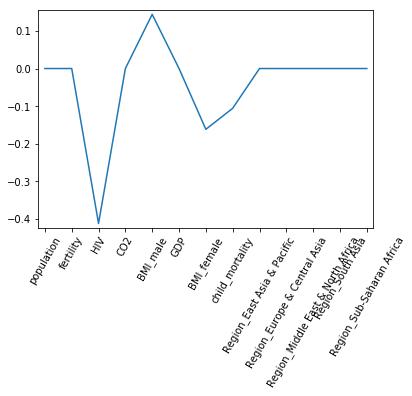

In [74]:
# Plot the coefficients
plt.plot(range(len(X.columns)), lasso_coef)
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.margins(0.02)
plt.show()


In [75]:
# use cross validation
cv_scores = cross_val_score(lasso, X, y, cv = 5)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 5-Fold CV Score R^2: {}".format(np.mean(cv_scores)))


[0.85739051 0.78360233 0.8563627  0.83083335 0.8480256 ]
Average 5-Fold CV Score R^2: 0.8352428970408429


### Regularization with Elastic Net: Grid Search and Hold-out 

In [81]:
# Create the hyperparameter grid
l1_space = np.logspace(-4, 0, 50)
param_grid = {'l1_ratio': l1_space}
# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(normalize = True)
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, iid = False)

In [82]:
# Fit it to the training data
gm_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'l1_ratio': array([1.00000e-04, 1.20679e-04, 1.45635e-04, 1.75751e-04, 2.12095e-04,
       2.55955e-04, 3.08884e-04, 3.72759e-04, 4.49843e-04, 5.42868e-04,
       6.55129e-04, 7.90604e-04, 9.54095e-04, 1.15140e-03, 1.38950e-03,
       1.67683e-03, 2.02359e-03, 2.44205e-03, 2.94705e-03, 3... 3.23746e-01, 3.90694e-01,
       4.71487e-01, 5.68987e-01, 6.86649e-01, 8.28643e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2     = gm_cv.score(X_test, y_test)
mse    = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(round(r2, 2)))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.84
Tuned ElasticNet MSE: 10.144762014599417
